Rainfall Prediction is one of the difficult and uncertain tasks that have a significant impact on human society. Timely and accurate forecasting can proactively help reduce human and financial loss. This study presents a set of experiments that involve the use of common machine learning techniques to create models that can predict whether it will rain tomorrow or not based on the weather data for that day in major cities in Australia.

We’ve always liked knowing the parameters meteorologists take into account before making a weather forecast, so we found the dataset interesting. From an expert’s point of view, however, this dataset is fairly straightforward. At the end of this project, we will learn:

* How is balancing done for an unbalanced dataset
* How Label Coding is done for Categorical Variables
* How sophisticated imputation like **MICE** is used
* How outliers can be detected and excluded from the data
* How the filter method and wrapper methods are used for feature selection
* How to compare speed and performance for different popular models
* Which metric can be the best to judge the performance on an unbalanced data set: **precision** and **F1 score**.

In [2]:
import pandas as pd
# from google.colab import files
# uploaded = files.upload()
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
full_data.shape

(142193, 24)

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

`RainToday` and `RainTomorrow` are objects (`Yes / No`). We will convert them to binary (`1/0`) for our convenience.

In [5]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Next, we will check if the dataset is unbalanced or balanced. If the data set is unbalanced, we need to either downsample the majority or oversample the minority to balance it.

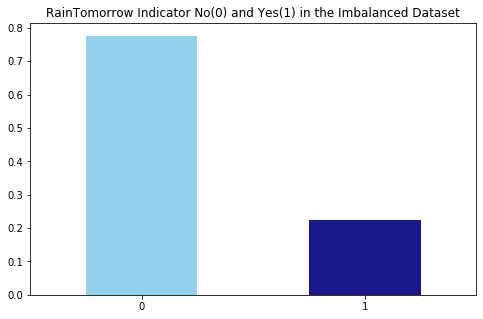

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', 
                                                           color= ['skyblue','navy'], 
                                                           alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can observe that the presence of `0` and `1` are almost in **78:22 ratio**. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use **oversampling of the minority class** here. Since the size of the dataset is quite small, **majority class subsampling** wouldn’t make much sense here.

In [7]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

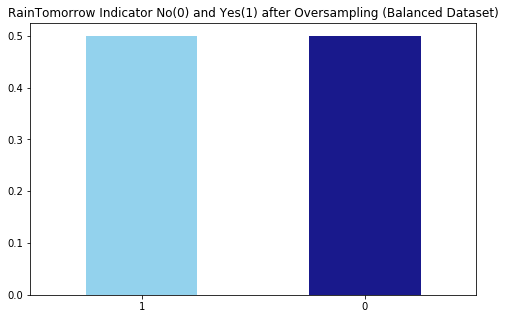

In [8]:
fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar',
                                                             color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

Now, we will check the missing data model in the dataset:

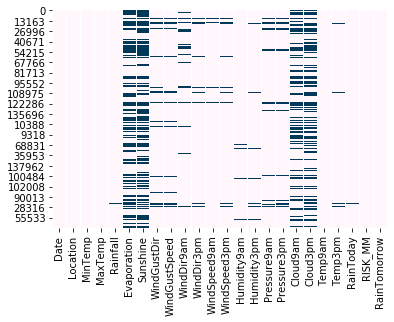

In [9]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

Obviously, `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm` are the features with a high missing percentage. So we will check the details of the missing data for these 4 features.

In [10]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


We observe that the 4 features have less than 50 percent missing data. So instead of rejecting them completely, we’ll consider them in our model with proper imputation.

### Imputation and Transformation

We will impute the categorical columns with **mode** and then use the **label encoder** to convert them to numeric numbers. Once all the columns in the dataframe are converted to numeric columns, we will impute the missing values using the **Multiple Imputation by Chained Equations (MICE)** package.

Next we will detect outliers using the interquartile range and remove them to get the final working dataset. Finally, we will check the correlation between the different variables, and if we find a pair of highly correlated variables, we will discard one while keeping the other.

In [11]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [12]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [13]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder

lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [14]:
import warnings
warnings.filterwarnings("ignore")

# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

Thus, the dataframe has no **NaN** value. We will now detect and eliminate outliers from the inter-quartile interval-based dataset.

In [15]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [16]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

We are now going to check **multicollinearity**, that is to say if a character is strongly correlated with another.

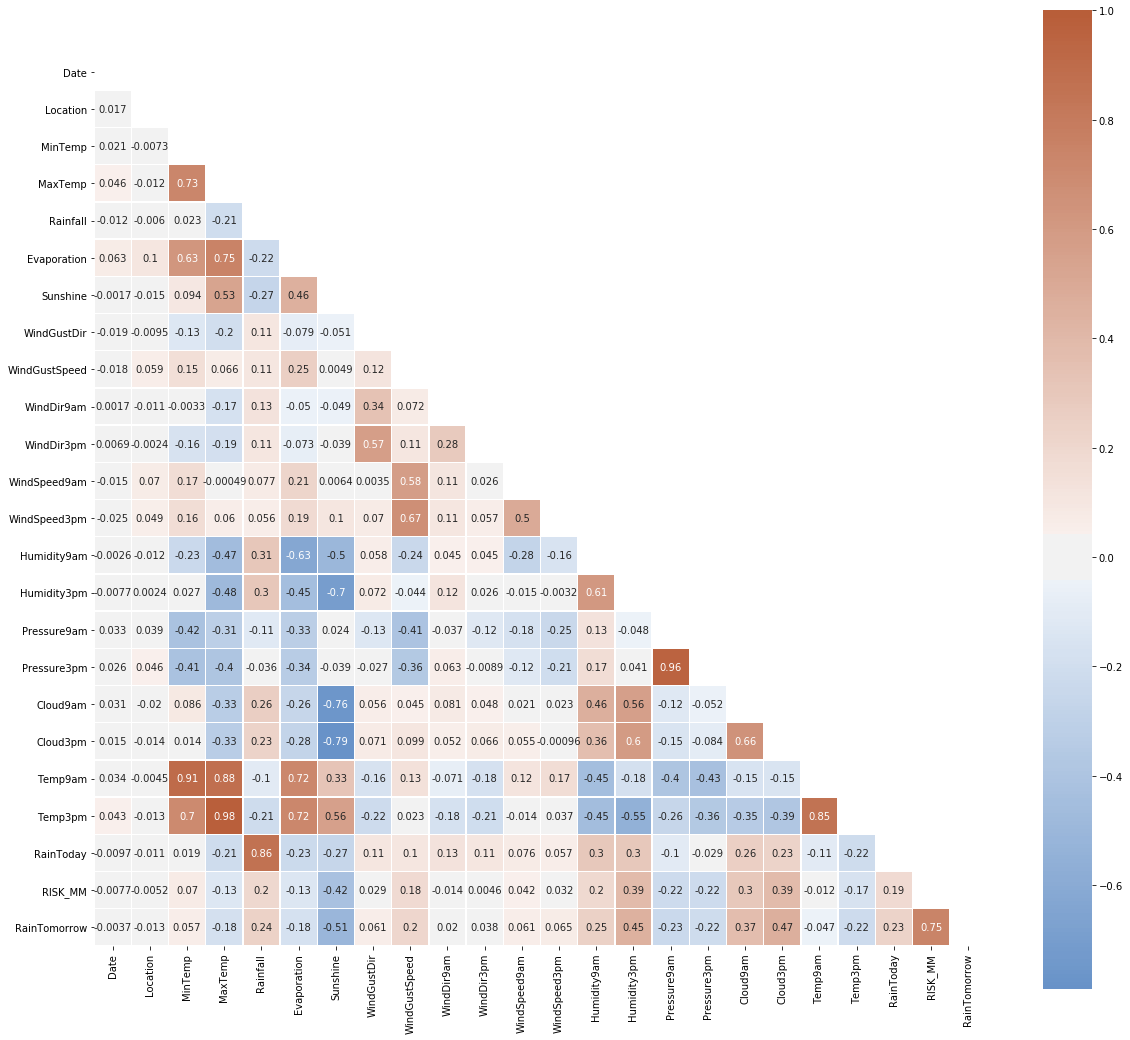

In [18]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, 
            annot=True, linewidths=.5, cbar_kws={"shrink": .9})
plt.show()

The following feature pairs have a strong correlation with each other:

* MaxTemp and MinTemp
* Pressure9h and pressure3h
* Temp9am and Temp3pm
* Evaporation and MaxTemp
* MaxTemp and Temp3pm But in no case is the correlation value equal to a perfect `1`. We are therefore not removing any functionality

However, we can delve deeper into the pairwise correlation between these highly correlated characteristics by examining the following pair diagram. Each of the paired plots shows very clearly distinct clusters of RainTomorrow’s `yes` and `no` clusters. There is very minimal overlap between them.

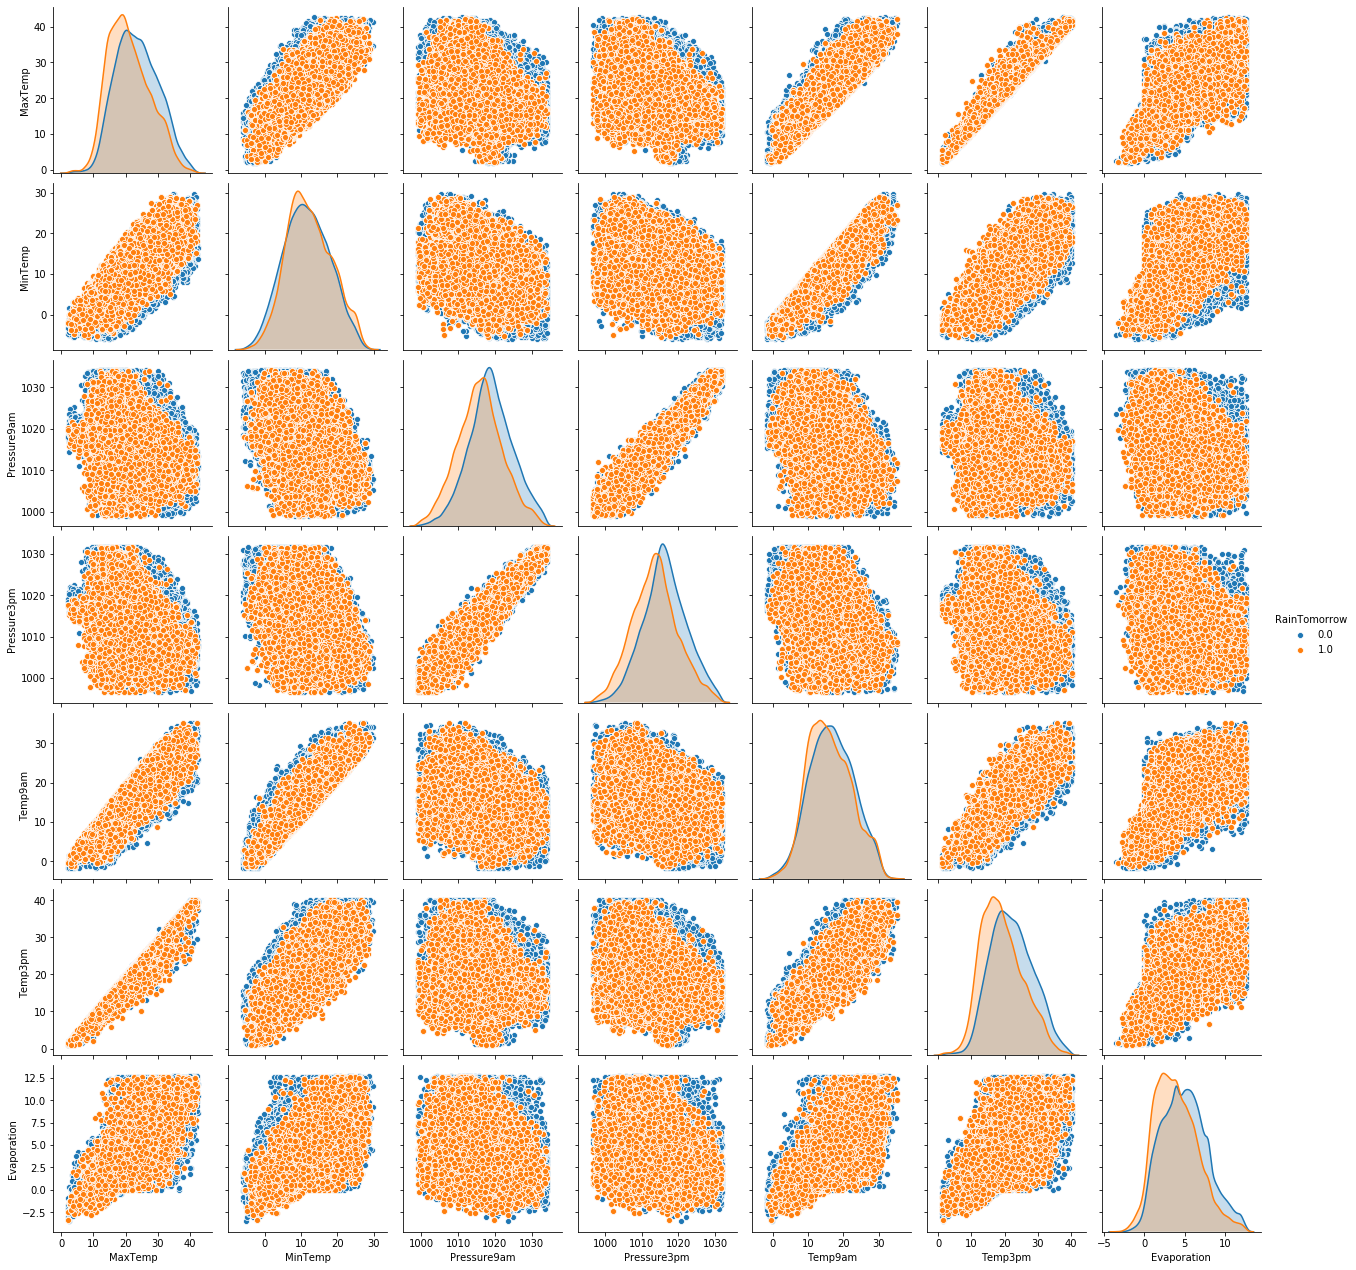

In [19]:
sns.pairplot(data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 
                                      'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )
plt.show()

### Feature Selection

We will use both the filter method and the wrapper method for feature selection to train our rainfall prediction model.

Selecting features by filtering method **(chi-square value)**: before doing this, we must first normalize our data. We use `MinMaxScaler` instead of `StandardScaler` in order to avoid negative values.

In [20]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed),
                             index=MiceImputed.index, columns=MiceImputed.columns)

In [22]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]

In [23]:
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
X.columns[selector.get_support(indices=True)]

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')

We can observe that `Sunshine`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm` have higher importance compared to other features.

In [24]:
# Selection of features by wrapping method (random forest):
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()

print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00205993 0.00215407 0.00259089 0.00367568 0.0102656  0.00252838
 0.05894157 0.00143001 0.00797518 0.00177178 0.00167654 0.0014278
 0.00187743 0.00760691 0.03091966 0.00830365 0.01193018 0.02113544
 0.04962418 0.00270103 0.00513723 0.00352198 0.76074491]


### Training Rainfall Prediction Model with Different Models

We will divide the dataset into **training (`75%`)** and **testing (`25%`)** sets respectively to train the rainfall prediction model. For best results, we will standardize our `X_train` and `X_test` data:

In [25]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]

target = MiceImputed['RainTomorrow']

In [26]:
# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25,
                                                    random_state=12345)

In [27]:
# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [28]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [30]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.78963609007217
ROC Area under Curve = 0.76976981489154
Cohen's Kappa = 0.5494516226632338
Time taken = 5.371593475341797
              precision    recall  f1-score   support

         0.0    0.80822   0.85949   0.83307     23948
         1.0    0.75520   0.68005   0.71566     15265

    accuracy                        0.78964     39213
   macro avg    0.78171   0.76977   0.77436     39213
weighted avg    0.78758   0.78964   0.78736     39213



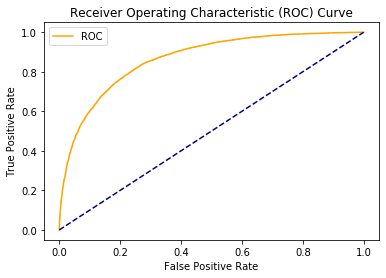

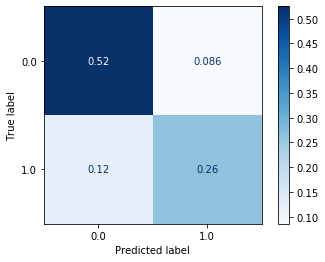

In [31]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train,
                                                                 X_test, y_test)

Accuracy = 0.8415576466987988
ROC Area under Curve = 0.835484478024255
Cohen's Kappa = 0.6681678212489894
Time taken = 0.7662920951843262
              precision    recall  f1-score   support

         0.0    0.87582   0.86291   0.86932     23948
         1.0    0.78979   0.80806   0.79882     15265

    accuracy                        0.84156     39213
   macro avg    0.83281   0.83548   0.83407     39213
weighted avg    0.84233   0.84156   0.84187     39213



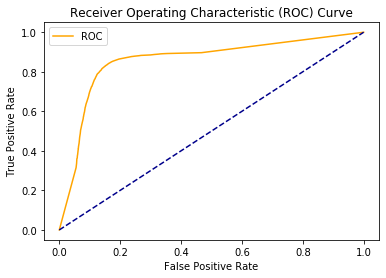

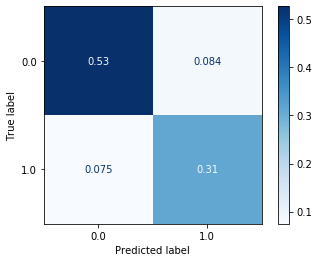

In [32]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, 
                                                                 X_test, y_test)

Accuracy = 0.8899344605105449
ROC Area under Curve = 0.8855064630971647
Cohen's Kappa = 0.769094818764464
Time taken = 423.8451838493347
              precision    recall  f1-score   support

         0.0    0.91351   0.90550   0.90949     23948
         1.0    0.85376   0.86551   0.85960     15265

    accuracy                        0.88993     39213
   macro avg    0.88364   0.88551   0.88454     39213
weighted avg    0.89025   0.88993   0.89007     39213



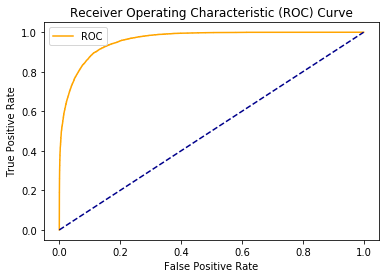

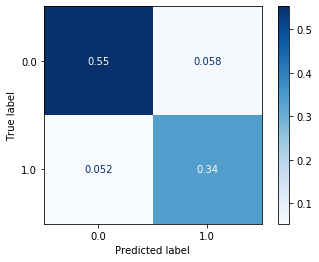

In [33]:
# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train,
                                                                 X_test, y_test)

Accuracy = 0.9280595720806876
ROC Area under Curve = 0.9265770863620824
Cohen's Kappa = 0.8493714659078331
Time taken = 45.950828075408936
              precision    recall  f1-score   support

         0.0    0.94812   0.93327   0.94064     23948
         1.0    0.89783   0.91988   0.90872     15265

    accuracy                        0.92806     39213
   macro avg    0.92297   0.92658   0.92468     39213
weighted avg    0.92854   0.92806   0.92821     39213



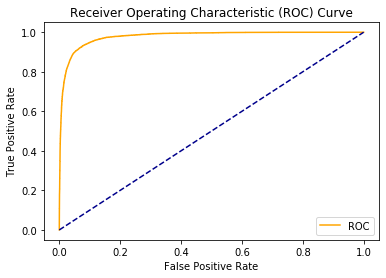

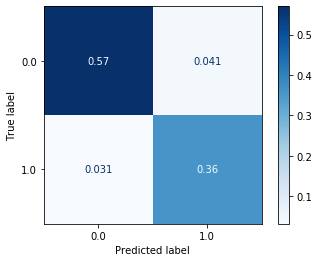

In [34]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, 
                                                                 X_test, y_test)

In [37]:
# !pip install lightgbm

Accuracy = 0.8684619896462907
ROC Area under Curve = 0.860694163700355
Cohen's Kappa = 0.7228133047900757
Time taken = 6.145763158798218
              precision    recall  f1-score   support

         0.0    0.88961   0.89577   0.89268     23948
         1.0    0.83469   0.82561   0.83013     15265

    accuracy                        0.86846     39213
   macro avg    0.86215   0.86069   0.86140     39213
weighted avg    0.86823   0.86846   0.86833     39213



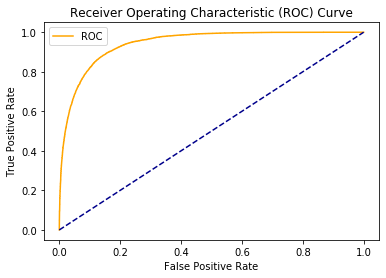

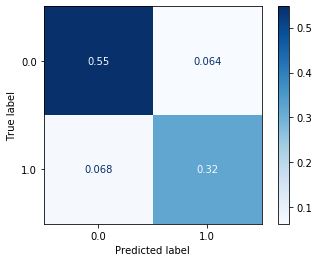

In [38]:
# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, 
                                                                      y_train, X_test, y_test)

In [ ]:
# !pip install catboost

Accuracy = 0.9418560171371739
ROC Area under Curve = 0.9449267946584342
Cohen's Kappa = 0.8791826232502136
Time taken = 633.0054640769958
              precision    recall  f1-score   support

         0.0    0.97256   0.93106   0.95136     23948
         1.0    0.89863   0.95879   0.92774     15265

    accuracy                        0.94186     39213
   macro avg    0.93560   0.94493   0.93955     39213
weighted avg    0.94378   0.94186   0.94216     39213



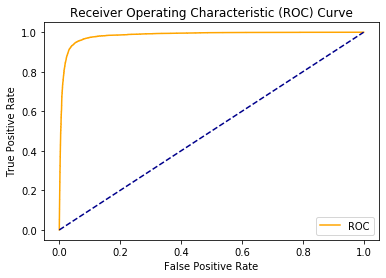

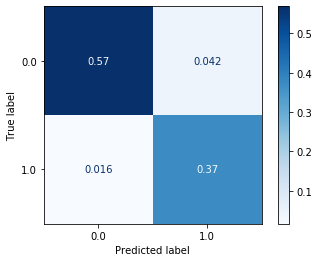

In [40]:
# Catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train,
                                                                 X_test, y_test, verbose=False)

In [43]:
# pip install xgboost

[15:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.9563665111060108
ROC Area under Curve = 0.9565810552736519
Cohen's Kappa = 0.908683590430594
Time taken = 222.09255290031433
              precision    recall  f1-score   support

         0.0    0.97246   0.95561   0.96396     23948
         1.0    0.93221   0.95755   0.94471     15265

    accuracy                        0.95637     39213
   macro avg    0.95234   0.95658   0.95434     39213
weighted avg    0.95679   0.95637   0.95647     39213



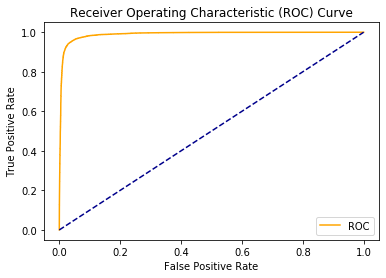

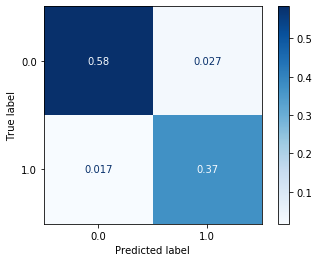

In [44]:
# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, 
                                                                      X_test, y_test)

### Plotting Decision Region for all Models

In [48]:
# pip install mlxtend

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import mlxtend
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

In [49]:
value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

In [50]:
X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[15:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[15:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

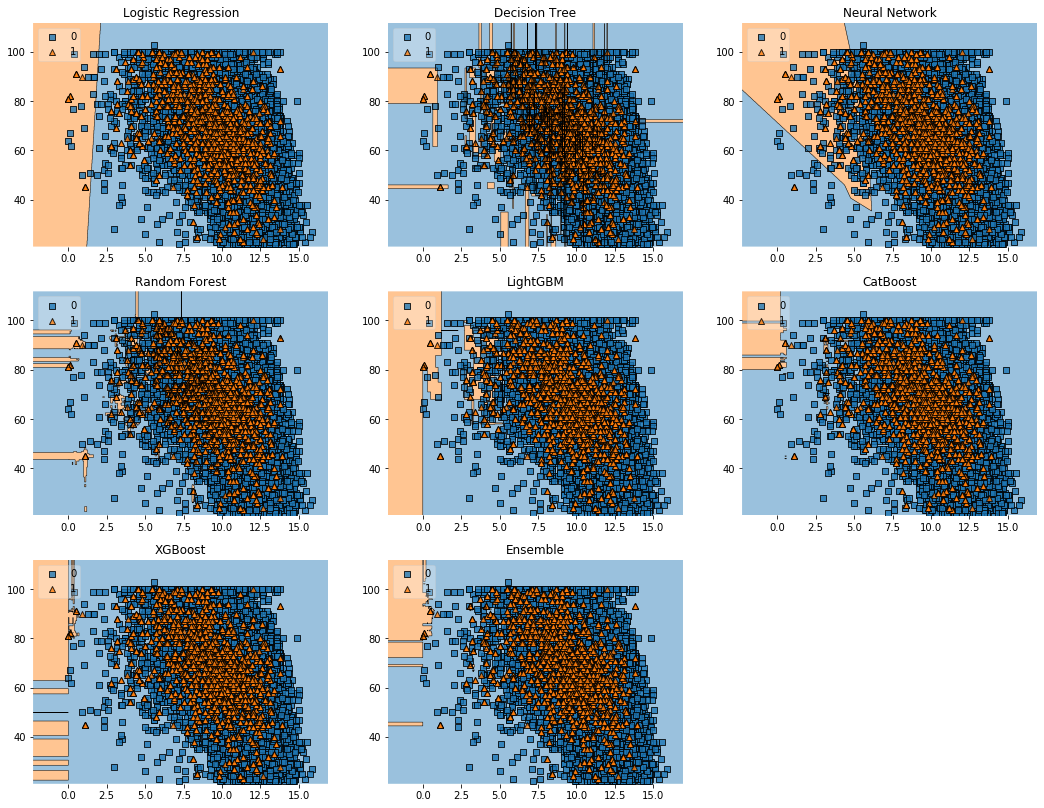

In [51]:
# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression','Decision Tree','Neural Network','Random Forest',
          'LightGBM','CatBoost','XGBoost','Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

We can observe the difference in the class limits for different models, including the set one (the plot is done considering only the training data). 
* **CatBoost** has the distinct regional border compared to all other models. 
* However, the **XGBoost** and **Random Forest** models also have a much lower number of misclassified data points compared to other models.

### Rainfall Prediction Model Comparison

Now we need to decide which model performed best based on **Precision Score**, **ROC_AUC**, **Cohen’s Kappa** and **Total Run Time**. One point to mention here is: we could have considered **F1-Score** as a better metric for judging model performance instead of accuracy, but we have already converted the unbalanced dataset to a balanced one, so consider accuracy as a metric for deciding the best model is justified in this case.

For a better decision, we chose **Cohen’s Kappa** which is actually an ideal choice as a metric to decide on the best model in case of unbalanced datasets. Let’s check which model worked well on which front:

In [52]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, 
                   accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb,
                  roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb,
                  coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

In [53]:
model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest',
                        'LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

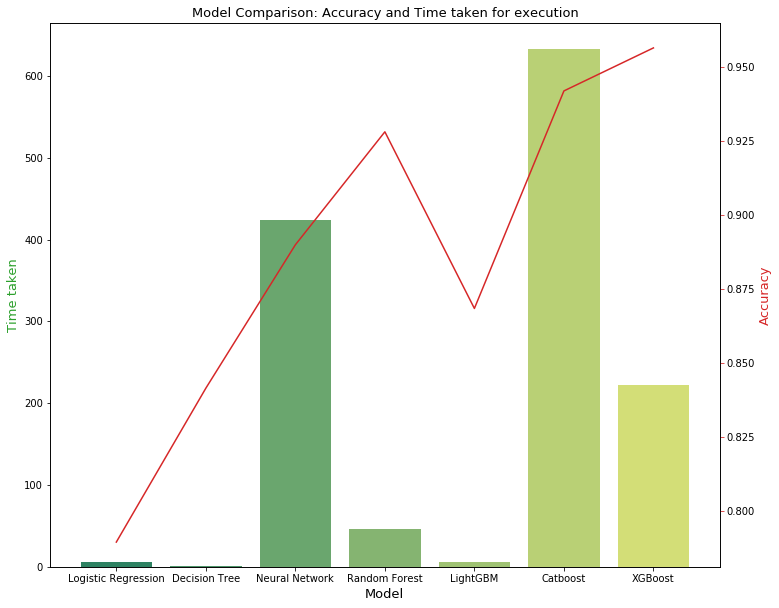

In [54]:
fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

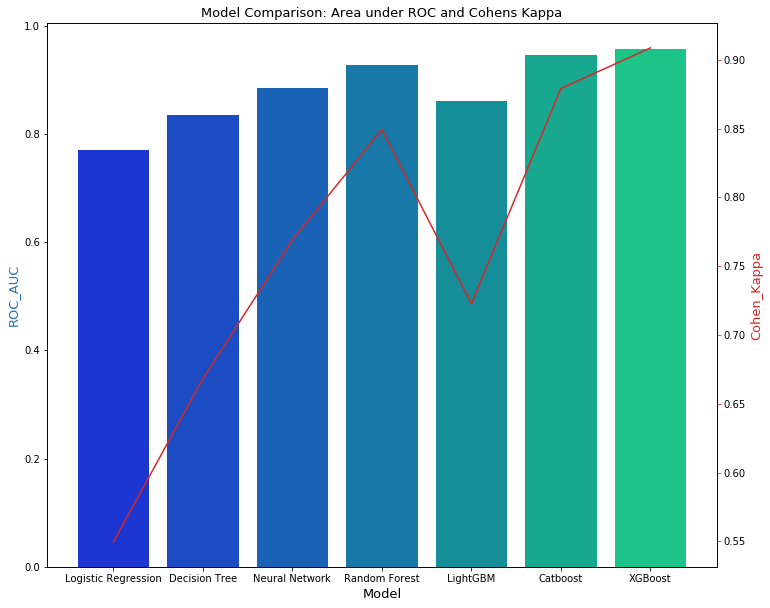

In [55]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

We can observe that **XGBoost**, **CatBoost** and **Random Forest** performed better compared to other models. However, if speed is an important thing to consider, we can stick with **Random Forest** instead of **XGBoost** or **CatBoost**.